# PSD plots

Loads depth-frequency-time PSD data and then plots for various circumstances.

## Imports
Necessary modules for analysis.

In [1]:
# import modules

import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import chi2
from scipy.optimize import curve_fit
for i in range(2):
    %matplotlib notebook

## Depth specific PSD (annual)

In [2]:
# import data

adcp = 'Axis75'     # Slope(2013,2014,2017,2018), Axis75(2013,2014), Axis55(2017,2018)
year = 2013

ds_in = xr.open_dataset(f'../Data/data/spectra/spectra_{adcp}_{year}_0.nc')
n_seg = ds_in.n_seg
ds = [ds_in]
if n_seg > 1:
    for i in range(n_seg):
        if i > 0:
            ds_temp = xr.open_dataset(f'../Data/data/spectra/spectra_{adcp}_{year}_{i}.nc')
            ds.append(ds_temp)

#print(ds)

In [3]:
# extract plotting variables & GM

t_stamp = int(ds[0].t_stamp)
depth = ds[0].depth.values
f = ds[0].specf.values

# GM spectrum

gm = np.loadtxt('../project/archive/GM/gm.dat')   # get GM data from separate code
gm_freq = gm[:,0]                                # GM based on N at -904 m
gm_psd = gm[:,1]
gm_cw = gm[:,2]
gm_ccw = gm[:,3]

In [4]:
# check for specific errors

# fig,ax = plt.subplots(1,1,figsize=(13,5))
# ax.loglog(ds[1].specf[64:112],ds[1].Sxxu[40,64:112,25:35])
# plt.show()

In [5]:
# select and average time

# set date range

start_date = dt.datetime(t_stamp,1,1)                                   # input start date in YYYY,MM,DD
end_date = dt.datetime(t_stamp+1,1,1)                                   # input end date in YYYY,MM,DD

dt_list,phi_u,phi_v = [],[],[]
for i in range(n_seg):
    dt_temp = pd.Series(pd.to_datetime(ds[i].spect.values))
    t_seg = len(dt_temp)
    for j in range(t_seg):
        if dt_temp[j] >= start_date and dt_temp[j] <= end_date:
            dt_list.append(ds[i].spect[j].values)
            phi_u.append(ds[i].Sxxu[:,:,j])                 # time segment, [depth, freq]
            phi_v.append(ds[i].Sxxv[:,:,j])
avg_u = sum(phi_u)/len(dt_list)
avg_v = sum(phi_v)/len(dt_list)
            
print("Output time range:",dt_list[0],'to',dt_list[-1])     # print to check desired interval

Output time range: 2013-01-06T08:07:30.000000000 to 2013-12-21T16:07:30.000000000


In [115]:
# WKB scale and select depth

WKB_u = avg_u / ds[0].WKB_scale
WKB_v = avg_v / ds[0].WKB_scale

if adcp == 'Slope':
    didx = -24           # -9 for lower depth (-315), -24 for mid-depth (-195)
elif adcp == 'Axis75':
    didx = -52            # -600
    #didx = -47          # -600
    #didx = -22           # -7 for lower depth (-920), -22 for mid-depth (-800)
elif adcp == 'Axis55':
    didx = -10           # -4 for lower depth (-913), -10 for mid-depth (-793)
    
u = WKB_u[didx,:].values         
v = WKB_v[didx,:].values
d_stamp = ds[0].depth[didx].values

#depth_u = WKB_u.mean(dim='depth')
#depth_v = WKB_v.mean(dim='depth')

print('Depth:',-d_stamp,'m')

Depth: -560 m


In [116]:
# error bars (95% confidence intervals) for each depth

probability = 0.95                            # calculate confidence intervals
alpha = 1 - probability        
NS = ds[0].t / (ds[0].nps / 2)                # number of estimates, Welch
vp = (4/3)*NS                                 # for tapered windows
cp = chi2.ppf([1 - alpha / 2, alpha / 2], vp) # chi**2 distribution
cint = vp/cp                                  # interval coefficients

u_lower = u * cint[0]             # define upper and lower confidence values
u_upper = u * cint[1]
v_lower = v * cint[0]             # define upper and lower confidence values
v_upper = v * cint[1]

In [117]:
# continuum fits (7e-5 to 1.2e-4 Hz)

lowf = 64                    # set frequency range for continuum
highf = 112

f_range = f[lowf:highf]      # set data range for continuum
u_range = u[lowf:highf]
v_range = v[lowf:highf]

def power_law(x,a,b):        # power law
    return a*np.power(x,b)

# Fit the power-law data
upars, ucov = curve_fit(f=power_law, xdata=f_range, ydata=u_range, p0=[1e-8, -2])
vpars, vcov = curve_fit(f=power_law, xdata=f_range, ydata=v_range, p0=[1e-8, -2])
# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
ustdevs = np.sqrt(np.diag(ucov))
vstdevs = np.sqrt(np.diag(vcov))
# Calculate the residuals
ures = u_range - power_law(f_range, *upars)
vres = v_range - power_law(f_range, *vpars)

ua = upars[0]       # get a and b coefficients
ub = upars[1]
va = vpars[0]
vb = vpars[1]

In [ ]:
# plot PSD

fig, ax = plt.subplots(1,1,figsize=(8,7))

ax.axvline(1.161e-5, color ='grey',lw=1,alpha=0.8) # constituents
ax.axvline(1.732e-5, color ='grey', lw=1)    
ax.axvline(2.236e-5, color ='grey',lw=1)
ax.axvline(3.968e-5, color ='grey',lw=1)
ax.axvline(4.472e-5, color ='grey',lw=1)
ax.axvline(6.709e-5, color ='grey',lw=1)
ax.axvline(4.026e-4, color ='grey',lw=1)
fig.text(0.38,0.17,'K$_1$',fontsize=14)
fig.text(0.442,0.17,'$f$',fontsize=14)
fig.text(0.459,0.17,'M$_2$',fontsize=14)
fig.text(0.522,0.17,'$f$M$_2$',fontsize=14)
fig.text(0.58,0.17,'M$_4$',fontsize=14)
fig.text(0.632,0.17,'M$_6$',fontsize=14)
fig.text(0.86,0.17,'N',fontsize=14)
fig.text(0.125,0.89,'WKB-scaled',fontsize=14)
fig.text(0.38,0.89,f'-{d_stamp} m - {adcp} - {t_stamp}',fontsize=14)

x_diurnal = [1.08e-5,1.30e-5]
x_inertial = [1.52e-5,1.95e-5]
x_semidiurnal = [2.17e-5,2.39e-5]
y_up = [1e4,1e4]
y_down = [1e-3,1e-3]
ax.fill_between(x_diurnal,y_up,y_down,color='green',alpha=0.2)
ax.fill_between(x_inertial,y_up,y_down,color='green',alpha=0.2)
ax.fill_between(x_semidiurnal,y_up,y_down,color='green',alpha=0.2,label='Int. range')

ax.set_ylim(1e-2,3e3)          # set y limits for comparing PSD
ax.set_xlim(1.27e-6, 5.55e-4)  # first non-zero freq bin to the Nyquist freq 

ax.tick_params(axis='both', direction='in', which='both', labelsize=14)
ax.set_ylabel('Power spectral density [(m/s)$^2$/Hz]',fontsize=14)
ax.set_xlabel('Frequency [Hz]',fontsize=14)

if adcp == 'Axis75' or adcp == 'Slope':
    ax.axhline(2.3e-2,color='black',ls=(0,(3,8,1,8)),lw=1,label='Noise floor')
elif adcp == 'Axis55':
    ax.axhline(0.53,color='black',ls=(0,(3,8,1,8)),lw=1,label='Noise floor')
    
ax.loglog(gm_freq/(2*np.pi),gm_psd*(np.pi),color='black',lw=1.2,ls='--', label='GM79: 1/2') # 1/2 GM for components

if adcp == 'Slope':
    ax.loglog(f, u, label='Cross-slope',color='blue')
    ax.loglog(f, v, label='Along-slope',color='red')
elif adcp == 'Axis55' or adcp == 'Axis75':
    ax.loglog(f, u, label='Cross-canyon',color='blue')
    ax.loglog(f, v, label='Along-canyon',color='red')

ax.fill_between(f, u_lower, u_upper, facecolor='blue', alpha=0.2)
ax.fill_between(f, v_lower, v_upper, facecolor='red', alpha=0.2,label='95% conf.')

ax.loglog(f_range,ua*f_range**ub,color='black',lw=3)
ax.loglog(f_range,va*f_range**vb,color='black',lw=3)

if adcp == 'Slope':
    fig.text(0.14,0.40,r'Cross-slope $af^b$:',fontsize=13)
    fig.text(0.14,0.28,r'Along-slope $af^b$:',fontsize=13)
elif adcp == 'Axis75' or adcp == 'Axis55':
    fig.text(0.14,0.40,r'Cross-canyon $af^b$:',fontsize=13)
    fig.text(0.14,0.28,r'Along-canyon $af^b$:',fontsize=13)
fig.text(0.14,0.36,'a = {:.2e}'.format(ua),fontsize=13)
fig.text(0.14,0.32,'b = %.2f'%ub,fontsize=13)
fig.text(0.14,0.24,'a = {:.2e}'.format(va),fontsize=13)
fig.text(0.14,0.20,'b = %.2f'%vb,fontsize=13)

#fig.tight_layout()
plt.legend(loc=[0.665,0.70],frameon=False,fontsize=13)
plt.show()

plt.savefig(fname=f'./plots/psd_plots/psd_{adcp}_{d_stamp}_{t_stamp}.pdf',format='pdf')

<IPython.core.display.Javascript object>


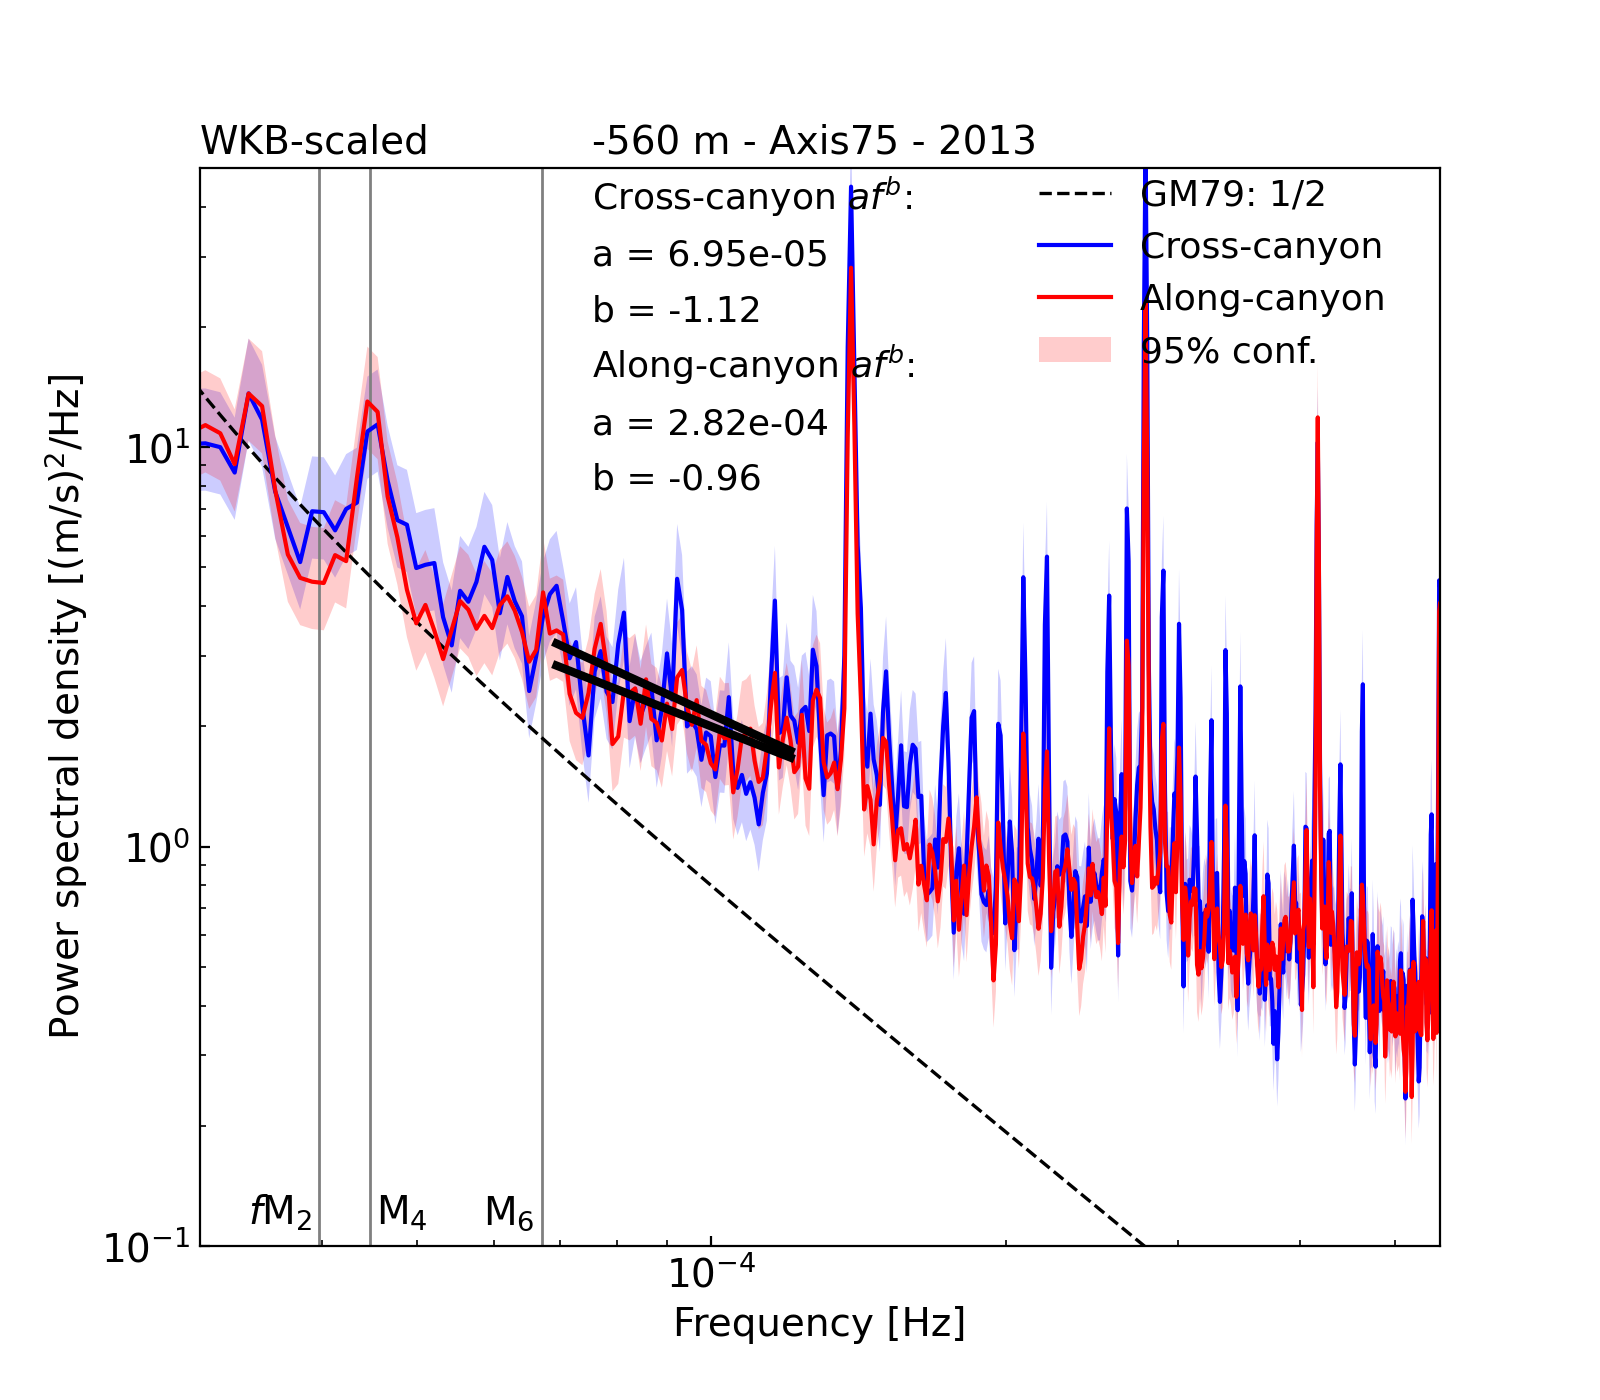

In [118]:
# plot test PSD

fig, ax = plt.subplots(1,1,figsize=(8,7))

ax.axvline(1.161e-5, color ='grey',lw=1,alpha=0.8) # constituents
ax.axvline(1.732e-5, color ='grey', lw=1)    
ax.axvline(2.236e-5, color ='grey',lw=1)
ax.axvline(3.968e-5, color ='grey',lw=1)
ax.axvline(4.472e-5, color ='grey',lw=1)
ax.axvline(6.709e-5, color ='grey',lw=1)
#ax.axvline(4.026e-4, color ='grey',lw=1)
# fig.text(0.38,0.17,'K$_1$',fontsize=14)
# fig.text(0.442,0.17,'$f$',fontsize=14)
# fig.text(0.459,0.17,'M$_2$',fontsize=14)
fig.text(0.155,0.125,'$f$M$_2$',fontsize=14)
fig.text(0.235,0.125,'M$_4$',fontsize=14)
fig.text(0.302,0.125,'M$_6$',fontsize=14)
# fig.text(0.86,0.17,'N',fontsize=14)
fig.text(0.125,0.89,'WKB-scaled',fontsize=14)
fig.text(0.37,0.89,f'-{d_stamp} m - {adcp} - {t_stamp}',fontsize=14)

x_diurnal = [1.08e-5,1.30e-5]
x_inertial = [1.52e-5,1.95e-5]
x_semidiurnal = [2.17e-5,2.39e-5]
y_up = [1e4,1e4]
y_down = [1e-3,1e-3]
ax.fill_between(x_diurnal,y_up,y_down,color='green',alpha=0.2)
ax.fill_between(x_inertial,y_up,y_down,color='green',alpha=0.2)
#ax.fill_between(x_semidiurnal,y_up,y_down,color='green',alpha=0.2,label='Int. range')

ax.set_ylim(1e-1,5e1)          # set y limits for comparing PSD
ax.set_xlim(3e-5,f[-1])  # first non-zero freq bin to the Nyquist freq 

ax.tick_params(axis='both', direction='in', which='both', labelsize=14)
ax.set_ylabel('Power spectral density [(m/s)$^2$/Hz]',fontsize=14)
ax.set_xlabel('Frequency [Hz]',fontsize=14)

#if adcp == 'Axis75' or adcp == 'Slope':
   # ax.axhline(2.3e-2,color='black',ls=(0,(3,8,1,8)),lw=1,label='Noise floor')
#elif adcp == 'Axis55':
 #   ax.axhline(0.53,color='black',ls=(0,(3,8,1,8)),lw=1,label='Noise floor')
    
ax.loglog(gm_freq/(2*np.pi),gm_psd*(np.pi),color='black',lw=1.2,ls='--', label='GM79: 1/2') # 1/2 GM for components

if adcp == 'Slope':
    ax.loglog(f, u, label='Cross-slope',color='blue')
    ax.loglog(f, v, label='Along-slope',color='red')
elif adcp == 'Axis55' or adcp == 'Axis75':
    ax.loglog(f, u, label='Cross-canyon',color='blue')
    ax.loglog(f, v, label='Along-canyon',color='red')

ax.fill_between(f, u_lower, u_upper, facecolor='blue', alpha=0.2)
ax.fill_between(f, v_lower, v_upper, facecolor='red', alpha=0.2,label='95% conf.')

ax.loglog(f_range,ua*f_range**ub,color='black',lw=3)
ax.loglog(f_range,va*f_range**vb,color='black',lw=3)

# if adcp == 'Slope':
#     fig.text(0.14,0.40,r'Cross-slope $af^b$:',fontsize=13)
#     fig.text(0.14,0.28,r'Along-slope $af^b$:',fontsize=13)
if adcp == 'Axis75' or adcp == 'Axis55':
    fig.text(0.37,0.85,r'Cross-canyon $af^b$:',fontsize=13)
    fig.text(0.37,0.73,r'Along-canyon $af^b$:',fontsize=13)
fig.text(0.37,0.81,'a = {:.2e}'.format(ua),fontsize=13)
fig.text(0.37,0.77,'b = %.2f'%ub,fontsize=13)
fig.text(0.37,0.69,'a = {:.2e}'.format(va),fontsize=13)
fig.text(0.37,0.65,'b = %.2f'%vb,fontsize=13)

#fig.tight_layout()
plt.legend(loc=[0.665,0.80],frameon=False,fontsize=13)
plt.show()

plt.savefig(fname=f'./plots/psd_plots/psd_noise_{adcp}_{d_stamp}_{t_stamp}.pdf',format='pdf')

In [ ]:
# plot fine PSD (change input file, first)

fig, ax = plt.subplots(1,1,figsize=(8,7))

ax.axvline(1.161e-5, color ='grey',lw=1,alpha=0.8) # constituents
ax.axvline(1.732e-5, color ='grey', lw=1)    
ax.axvline(2.236e-5, color ='grey',lw=1)
ax.axvline(3.968e-5, color ='grey',lw=1)
ax.axvline(4.472e-5, color ='grey',lw=1)
ax.axvline(6.709e-5, color ='grey',lw=1)
ax.axvline(4.026e-4, color ='grey',lw=1)
ax.text(1.07e-5,0.11,'K$_1$',fontsize=14)
ax.text(1.66e-5,0.11,'$f$',fontsize=14)
ax.text(2.03e-5,0.11,'M$_2$',fontsize=14)
ax.text(3.5e-5,0.11,'$f$M$_2$',fontsize=14)
ax.text(4.06e-5,0.11,'M$_4$',fontsize=14)
ax.text(6.09e-5,0.11,'M$_6$',fontsize=14)
#fig.text(0.86,0.17,'N',fontsize=14)
fig.text(0.125,0.89,'WKB-scaled',fontsize=14)
fig.text(0.38,0.89,f'-{d_stamp} m - {adcp} - {t_stamp}',fontsize=14)

x_diurnal = [1.08e-5,1.30e-5]
x_inertial = [1.52e-5,1.95e-5]
x_semidiurnal = [2.17e-5,2.39e-5]
y_up = [1e4,1e4]
y_down = [1e-3,1e-3]
#ax.fill_between(x_diurnal,y_up,y_down,color='green',alpha=0.2)
#ax.fill_between(x_inertial,y_up,y_down,color='green',alpha=0.2)
#ax.fill_between(x_semidiurnal,y_up,y_down,color='green',alpha=0.2,label='Int. range')

ax.set_ylim(1e-2,3e3)          # set y limits for comparing PSD
ax.set_xlim(1.27e-6, 5.55e-4)  # first non-zero freq bin to the Nyquist freq 

ax.tick_params(axis='both', direction='in', which='both', labelsize=14)
ax.set_ylabel('Power spectral density [(m/s)$^2$/Hz]',fontsize=14)
ax.set_xlabel('Frequency [Hz]',fontsize=14)

if adcp == 'Axis75' or adcp == 'Slope':
    ax.axhline(2.3e-2,color='black',ls=(0,(3,8,1,8)),lw=1,label='Noise floor')
elif adcp == 'Axis55':
    ax.axhline(0.53,color='black',ls=(0,(3,8,1,8)),lw=1,label='Noise floor')
    
ax.loglog(gm_freq/(2*np.pi),gm_psd*(np.pi),color='black',lw=1.2,ls='--', label='GM79: 1/2') # 1/2 GM for components

if adcp == 'Slope':
    ax.loglog(f, u, label='Cross-slope',color='blue')
    ax.loglog(f, v, label='Along-slope',color='red')
elif adcp == 'Axis55' or adcp == 'Axis75':
    ax.loglog(f, u, label='Cross-canyon',color='blue')
    ax.loglog(f, v, label='Along-canyon',color='red')

ax.fill_between(f, u_lower, u_upper, facecolor='blue', alpha=0.2)
ax.fill_between(f, v_lower, v_upper, facecolor='red', alpha=0.2,label='95% conf.')

ax.set_xlim(1e-5,1e-4)
ax.set_ylim(1e-1,3e3)

#fig.tight_layout()
plt.legend(loc=[0.71,0.758],frameon=True,fontsize=12,framealpha=1,edgecolor='white')
plt.show()

plt.savefig(fname=f'./plots/psd_plots/psd_fine_{adcp}_{d_stamp}_{t_stamp}.pdf',format='pdf')

## Inter-annual comparison

In [ ]:
# save annual data to .nc file

ds_out = xr.Dataset( 
    data_vars=dict(
        u=(['f'], u),    # PSD data
        v=(['f'], v),
    ),
    coords=dict(
        f=f,              
    ),
    attrs=dict(
        description=f'PSD data from {adcp} for {t_stamp}.',
        d_stamp = d_stamp,
        ua = ua,
        ub = ub,
        va = va,
        vb = vb,
        f_range = f_range,
    ),
) 
ds_out.to_netcdf(f'../Data/interannual/psd_{adcp}_{t_stamp}.nc')

In [ ]:
# plot multi-annual data

multi_adcp = 'Slope'       # Slope or Axis
if multi_adcp == 'Slope':
    ds0 = xr.open_dataset(f'../Data/interannual/psd_Slope_2013.nc')
    ds1 = xr.open_dataset(f'../Data/interannual/psd_Slope_2014.nc')
    ds2 = xr.open_dataset(f'../Data/interannual/psd_Slope_2017.nc')
    ds3 = xr.open_dataset(f'../Data/interannual/psd_Slope_2018.nc')
elif multi_adcp == 'Axis':
    ds0 = xr.open_dataset(f'../Data/interannual/psd_Axis75_2013.nc')
    ds1 = xr.open_dataset(f'../Data/interannual/psd_Axis75_2014.nc')
    ds2 = xr.open_dataset(f'../Data/interannual/psd_Axis55_2017.nc')
    ds3 = xr.open_dataset(f'../Data/interannual/psd_Axis55_2018.nc')

# extract plotting variables & GM

f = ds0.f

# GM spectrum

gm = np.loadtxt('../project/archive/GM/gm.dat')   # get GM data from separate code
gm_freq = gm[:,0]                                # GM based on N at -904 m
gm_psd = gm[:,1]
gm_cw = gm[:,2]
gm_ccw = gm[:,3]
    
multi_u = (ds0.u + ds1.u + ds2.u + ds3.u) / 4
multi_v = (ds0.v + ds1.v + ds2.v + ds3.v) / 4

# error bars (95% confidence intervals) for each depth

probability = 0.95                            # calculate confidence intervals
alpha = 1 - probability        
NS = ds[0].t / (ds[0].nps / 2)                # number of estimates, Welch
vp = (4/3)*NS                                 # for tapered windows
cp = chi2.ppf([1 - alpha / 2, alpha / 2], vp) # chi**2 distribution
cint = vp/cp                                  # interval coefficients

multi_u_lower = multi_u * cint[0]             # define upper and lower confidence values
multi_u_upper = multi_u * cint[1]          
multi_v_lower = multi_v * cint[0]             # define upper and lower confidence values
multi_v_upper = multi_v * cint[1]

# continuum fits (7e-5 to 1.2e-4 Hz)

lowf = 64                    # set frequency range for continuum
highf = 112

f_range = f[lowf:highf]      # set data range for continuum
u_range = multi_u[lowf:highf]
v_range = multi_v[lowf:highf]

def power_law(x,a,b):        # power law
    return a*np.power(x,b)

# Fit the power-law data
upars, ucov = curve_fit(f=power_law, xdata=f_range, ydata=u_range, p0=[1e-8, -2])
vpars, vcov = curve_fit(f=power_law, xdata=f_range, ydata=v_range, p0=[1e-8, -2])
# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
#ustdevs = np.sqrt(np.diag(ucov))
#vstdevs = np.sqrt(np.diag(vcov))
# Calculate the residuals
#ures = u_range - power_law(f_range, *upars)
#vres = v_range - power_law(f_range, *vpars)

ua = upars[0]       # get a and b coefficients
ub = upars[1]
va = vpars[0]
vb = vpars[1]

# plot PSD

fig, ax = plt.subplots(1,1,figsize=(8,7))

ax.axvline(1.161e-5, color ='grey',lw=1,alpha=0.8) # constituents
ax.axvline(1.732e-5, color ='grey', lw=1)    
ax.axvline(2.236e-5, color ='grey',lw=1)
ax.axvline(3.968e-5, color ='grey',lw=1)
ax.axvline(4.472e-5, color ='grey',lw=1)
ax.axvline(6.709e-5, color ='grey',lw=1)
ax.axvline(4.026e-4, color ='grey',lw=1)
fig.text(0.38,0.17,'K$_1$',fontsize=14)
fig.text(0.442,0.17,'$f$',fontsize=14)
fig.text(0.459,0.17,'M$_2$',fontsize=14)
fig.text(0.522,0.17,'$f$M$_2$',fontsize=14)
fig.text(0.58,0.17,'M$_4$',fontsize=14)
fig.text(0.632,0.17,'M$_6$',fontsize=14)
fig.text(0.86,0.17,'N',fontsize=14)
fig.text(0.125,0.89,'WKB-scaled',fontsize=14)
fig.text(0.41,0.89,f'-{ds0.d_stamp} m - {multi_adcp}',fontsize=14)

x_diurnal = [1.08e-5,1.30e-5]
x_inertial = [1.52e-5,1.95e-5]
x_semidiurnal = [2.17e-5,2.39e-5]
y_up = [1e4,1e4]
y_down = [1e-3,1e-3]
ax.fill_between(x_diurnal,y_up,y_down,color='green',alpha=0.2)
ax.fill_between(x_inertial,y_up,y_down,color='green',alpha=0.2)
ax.fill_between(x_semidiurnal,y_up,y_down,color='green',alpha=0.2,label='Int. ranges')

ax.set_ylim(1e-2,3e3)          # set y limits for comparing PSD
ax.set_xlim(1.27e-6, 5.55e-4)  # first non-zero freq bin to the Nyquist freq 

ax.tick_params(axis='both', direction='in', which='both', labelsize=14)
ax.set_ylabel('Power spectral density [(m/s)$^2$/Hz]',fontsize=14)
ax.set_xlabel('Frequency [Hz]',fontsize=14)

if multi_adcp == 'Slope':
    ax.axhline(2.3e-2,color='black',ls=(0,(3,8,1,8)),lw=1,label='Noise floor')
elif multi_adcp == 'Axis':
    ax.axhline(2.3e-2,color='black',ls=(0,(3,8,1,8)),lw=1,label='Noise floor')
    ax.axhline(0.53,color='black',ls=(0,(3,8,1,8)),lw=1)   

if multi_adcp == 'Slope':
    #ax.loglog(f, multi_u, label='Cross-slope',color='blue')
    ax.loglog(f, ds0.u, label='Cross-slope',color='blue')
    ax.loglog(f, ds1.u,color='blue')
    ax.loglog(f, ds2.u,color='blue')
    ax.loglog(f, ds3.u,color='blue')
    #ax.loglog(f, multi_v, label='Along-slope',color='red')
    ax.loglog(f, ds0.v, label='Along-slope',color='red')
    ax.loglog(f, ds1.v,color='red')
    ax.loglog(f, ds2.v,color='red')
    ax.loglog(f, ds3.v,color='red')
elif multi_adcp == 'Axis':
    #ax.loglog(f, multi_u, label='Cross-slope',color='blue')
    ax.loglog(f, ds0.u, label='Cross-canyon',color='blue')
    ax.loglog(f, ds1.u,color='blue')
    ax.loglog(f, ds2.u,color='blue')
    ax.loglog(f, ds3.u,color='blue')
    #ax.loglog(f, multi_v, label='Along-slope',color='red')
    ax.loglog(f, ds0.v, label='Along-canyon',color='red')
    ax.loglog(f, ds1.v,color='red')
    ax.loglog(f, ds2.v,color='red')
    ax.loglog(f, ds3.v,color='red')

ax.loglog(gm_freq/(2*np.pi),gm_psd*(np.pi),color='black',lw=1.2,ls='--', label='GM79: 1/2') # 1/2 GM for components
#ax.fill_between(f, multi_u_lower, multi_u_upper, facecolor='blue', alpha=0.2)
#ax.fill_between(f, multi_v_lower, multi_v_upper, facecolor='red', alpha=0.2,label='95% conf.')

#fig.tight_layout()
if multi_adcp == 'Slope':
    plt.legend(loc=[0.665,0.74],frameon=False,fontsize=13)
    ax.plot([1.1e-4,1.1e-4],[multi_u_lower[12],multi_u_upper[12]],color='black')
    ax.plot([1.08e-4,1.12e-4],[multi_u_lower[12],multi_u_lower[12]],color='black')
    ax.plot([1.08e-4,1.12e-4],[multi_u_upper[12],multi_u_upper[12]],color='black')
    fig.text(0.713,0.565,'95% conf.',fontsize=13)
    fig.text(0.14,0.17,'RDI',fontsize=14)
elif multi_adcp == 'Axis':
    plt.legend(loc=[0.65,0.74],frameon=False,fontsize=13)
    ax.plot([1e-4,1e-4],[multi_u_upper[10],multi_u_lower[10]],color='black')
    ax.plot([0.98e-4,1.02e-4],[multi_u_lower[10],multi_u_lower[10]],color='black')
    ax.plot([0.98e-4,1.02e-4],[multi_u_upper[10],multi_u_upper[10]],color='black')
    fig.text(0.7,0.585,'95% conf.',fontsize=13)
    fig.text(0.14,0.17,'RDI',fontsize=14)
    fig.text(0.14,0.36,'Nortek',fontsize=14)
    
ax.loglog(f_range,ua*f_range**ub,color='black',lw=4)
ax.loglog(f_range,va*f_range**vb,color='black',lw=4)
if multi_adcp == 'Slope':
    fig.text(0.14,0.44,r'Cross-slope $af^b$:',fontsize=13)
    fig.text(0.14,0.32,r'Along-slope $af^b$:',fontsize=13)
elif multi_adcp == 'Axis':
    fig.text(0.14,0.44,r'Cross-canyon $af^b$:',fontsize=13)
    fig.text(0.14,0.32,r'Along-canyon $af^b$:',fontsize=13)
fig.text(0.14,0.40,'a = {:.2e}'.format(ua),fontsize=13)
fig.text(0.14,0.36,'b = %.2f'%ub,fontsize=13)
fig.text(0.14,0.28,'a = {:.2e}'.format(va),fontsize=13)
fig.text(0.14,0.24,'b = %.2f'%vb,fontsize=13)    
    
plt.show()

plt.savefig(fname=f'./plots/interannual_plots/psd_{multi_adcp}_{ds0.d_stamp}.pdf',format='pdf')

In [ ]:
# plot w/ rotary data

# plot multi-annual data

multi_adcp = 'Slope'       # Slope or Axis
if multi_adcp == 'Slope':
    ds0 = xr.open_dataset(f'../Data/interannual/psd_Slope_2013.nc')
    ds1 = xr.open_dataset(f'../Data/interannual/psd_Slope_2014.nc')
    ds2 = xr.open_dataset(f'../Data/interannual/psd_Slope_2017.nc')
    ds3 = xr.open_dataset(f'../Data/interannual/psd_Slope_2018.nc')
elif multi_adcp == 'Axis':
    ds0 = xr.open_dataset(f'../Data/interannual/psd_Axis75_2013.nc')
    ds1 = xr.open_dataset(f'../Data/interannual/psd_Axis75_2014.nc')
    ds2 = xr.open_dataset(f'../Data/interannual/psd_Axis55_2017.nc')
    ds3 = xr.open_dataset(f'../Data/interannual/psd_Axis55_2018.nc')

# extract plotting variables & GM

f = ds0.f

# GM spectrum

gm = np.loadtxt('../project/archive/GM/gm.dat')   # get GM data from separate code
gm_freq = gm[:,0]                                # GM based on N at -904 m
gm_psd = gm[:,1]
gm_cw = gm[:,2]
gm_ccw = gm[:,3]    
    
multi_u = (ds0.u + ds1.u + ds2.u + ds3.u) / 4
multi_v = (ds0.v + ds1.v + ds2.v + ds3.v) / 4

# error bars (95% confidence intervals) for each depth

probability = 0.95                            # calculate confidence intervals
alpha = 1 - probability        
NS = ds[0].t / (ds[0].nps / 2)                # number of estimates, Welch
vp = (4/3)*NS                                 # for tapered windows
cp = chi2.ppf([1 - alpha / 2, alpha / 2], vp) # chi**2 distribution
cint = vp/cp                                  # interval coefficients

multi_u_lower = multi_u * cint[0]             # define upper and lower confidence values
multi_u_upper = multi_u * cint[1]          
multi_v_lower = multi_v * cint[0]             # define upper and lower confidence values
multi_v_upper = multi_v * cint[1]

# continuum fits (7e-5 to 1.2e-4 Hz)

lowf = 64                    # set frequency range for continuum
highf = 112

f_range = f[lowf:highf]      # set data range for continuum
u_range = multi_u[lowf:highf]
v_range = multi_v[lowf:highf]

def power_law(x,a,b):        # power law
    return a*np.power(x,b)

# Fit the power-law data
upars, ucov = curve_fit(f=power_law, xdata=f_range, ydata=u_range, p0=[1e-8, -2])
vpars, vcov = curve_fit(f=power_law, xdata=f_range, ydata=v_range, p0=[1e-8, -2])
# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
#ustdevs = np.sqrt(np.diag(ucov))
#vstdevs = np.sqrt(np.diag(vcov))
# Calculate the residuals
#ures = u_range - power_law(f_range, *upars)
#vres = v_range - power_law(f_range, *vpars)

ua = upars[0]       # get a and b coefficients
ub = upars[1]
va = vpars[0]
vb = vpars[1]

# import rotary data

if multi_adcp == 'Slope':
    ds0_rot = xr.open_dataset(f'../Data/interannual/rot_Slope_2013.nc')
    ds1_rot = xr.open_dataset(f'../Data/interannual/rot_Slope_2014.nc')
    ds2_rot = xr.open_dataset(f'../Data/interannual/rot_Slope_2017.nc')
    ds3_rot = xr.open_dataset(f'../Data/interannual/rot_Slope_2018.nc')
elif multi_adcp == 'Axis':
    ds0_rot = xr.open_dataset(f'../Data/interannual/rot_Axis75_2013.nc')
    ds1_rot = xr.open_dataset(f'../Data/interannual/rot_Axis75_2014.nc')
    ds2_rot = xr.open_dataset(f'../Data/interannual/rot_Axis55_2017.nc')
    ds3_rot = xr.open_dataset(f'../Data/interannual/rot_Axis55_2018.nc')
    
multi_cw = (ds0_rot.cw + ds1_rot.cw + ds2_rot.cw + ds3_rot.cw) / 4
multi_ccw = (ds0_rot.ccw + ds1_rot.ccw + ds2_rot.ccw + ds3_rot.ccw) / 4

# error bars (95% confidence intervals) for each depth

multi_cw_lower = multi_cw * cint[0]             # define upper and lower confidence values
multi_cw_upper = multi_cw * cint[1]          
multi_ccw_lower = multi_ccw * cint[0]             # define upper and lower confidence values
multi_ccw_upper = multi_ccw * cint[1]

# plot PSD

fig, (ax0,ax1) = plt.subplots(1,2,figsize=(13,7))

fig.subplots_adjust(wspace = 0.02)
fig.text(0.125,0.89,'WKB-scaled',fontsize=14)
fig.text(0.46,0.05,'Frequency [Hz]',fontsize=14)
fig.text(0.46,0.89,f'-{ds0.d_stamp} m - {multi_adcp}',fontsize=14)
fig.text(0.94,0.5,'Rotary PSD [(m/s)$^2$/Hz]',va='center',rotation='vertical',fontsize=14)
ax0.set_ylabel('Power spectral density [(m/s)$^2$/Hz]',fontsize=14)

x_diurnal = [1.08e-5,1.30e-5]
x_inertial = [1.52e-5,1.95e-5]
x_semidiurnal = [2.17e-5,2.39e-5]
y_up = [1e4,1e4]
y_down = [1e-3,1e-3]
axs = [ax0,ax1]
for i in axs:
    i.axvline(1.161e-5, color ='grey',lw=1,alpha=0.8) # constituents
    i.axvline(1.732e-5, color ='grey', lw=1)    
    i.axvline(2.236e-5, color ='grey',lw=1)
    i.axvline(3.968e-5, color ='grey',lw=1)
    i.axvline(4.472e-5, color ='grey',lw=1)
    i.axvline(6.709e-5, color ='grey',lw=1)
    i.axvline(4.026e-4, color ='grey',lw=1)
    i.text(0.85e-5,1.5e-2,'K$_1$',fontsize=14)
    i.text(1.34e-5,1.5e-2,'$f$',fontsize=14)
    i.text(1.82e-5,1.5e-2,'M$_2$',fontsize=14)
    i.text(2.7e-5,1.5e-2,'$f$M$_2$',fontsize=14)
    i.text(4.4e-5,1.5e-2,'M$_4$',fontsize=14)
    i.text(6.65e-5,1.5e-2,'M$_6$',fontsize=14)
    i.text(4.1e-4,1.5e-2,'N',fontsize=14)
    i.fill_between(x_diurnal,y_up,y_down,color='green',alpha=0.2)
    i.fill_between(x_inertial,y_up,y_down,color='green',alpha=0.2)
    i.fill_between(x_semidiurnal,y_up,y_down,color='green',alpha=0.2,label='Int. ranges')
    i.set_ylim(1e-2,1e3)          # set y limits for comparing PSD
    i.set_xlim(1.27e-6, 5.50e-4)  # first non-zero freq bin to the Nyquist freq 
    i.tick_params(axis='both', direction='in', which='both', labelsize=14) 

if multi_adcp == 'Slope':
    #ax.loglog(f, multi_u, label='Cross-slope',color='blue')
    ax0.loglog(f, ds0.u, label='Cross-slope',color='tab:blue')
    ax0.loglog(f, ds1.u,color='tab:blue')
    ax0.loglog(f, ds2.u,color='tab:blue')
    ax0.loglog(f, ds3.u,color='tab:blue')
    #ax.loglog(f, multi_v, label='Along-slope',color='red')
    ax0.loglog(f, ds0.v, label='Along-slope',color='tab:red')
    ax0.loglog(f, ds1.v,color='tab:red')
    ax0.loglog(f, ds2.v,color='tab:red')
    ax0.loglog(f, ds3.v,color='tab:red')
elif multi_adcp == 'Axis':
    #ax.loglog(f, multi_u, label='Cross-slope',color='blue')
    ax0.loglog(f, ds0.u, label='Cross-canyon',color='tab:blue')
    ax0.loglog(f, ds1.u,color='tab:blue')
    ax0.loglog(f, ds2.u,color='tab:blue')
    ax0.loglog(f, ds3.u,color='tab:blue')
    #ax.loglog(f, multi_v, label='Along-slope',color='red')
    ax0.loglog(f, ds0.v, label='Along-canyon',color='tab:red')
    ax0.loglog(f, ds1.v,color='tab:red')
    ax0.loglog(f, ds2.v,color='tab:red')
    ax0.loglog(f, ds3.v,color='tab:red')

#ax.loglog(f, multi_cw, label='CW',color='blue')
ax1.loglog(f, ds0_rot.cw, label='CW',color='tab:blue')
ax1.loglog(f, ds1_rot.cw,color='tab:blue')
ax1.loglog(f, ds2_rot.cw,color='tab:blue')
ax1.loglog(f, ds3_rot.cw,color='tab:blue')
#ax.loglog(f, multi_ccw, label='CCW',color='red')
ax1.loglog(f, ds0_rot.ccw, label='CCW',color='tab:red')
ax1.loglog(f, ds1_rot.ccw,color='tab:red')
ax1.loglog(f, ds2_rot.ccw,color='tab:red')
ax1.loglog(f, ds3_rot.ccw,color='tab:red')    

ax0.loglog(f_range,ua*f_range**ub,color='black',alpha=1,lw=3,label=r'$af^b$ fit')
ax0.loglog(f_range,va*f_range**vb,color='black',alpha=1,lw=3)
# fig.text(0.14,0.40,'a = {:.2e}'.format(ua),fontsize=13)
# fig.text(0.14,0.36,'b = %.2f'%ub,fontsize=13)
# fig.text(0.14,0.28,'a = {:.2e}'.format(va),fontsize=13)
# fig.text(0.14,0.24,'b = %.2f'%vb,fontsize=13) 
    
ax0.loglog(gm_freq/(2*np.pi),gm_psd*(np.pi),color='black',ls='--',lw=1.5, label='GM79: 1/2') # 1/2 GM for components
ax1.loglog(gm_freq/(2*np.pi),gm_cw*(2*np.pi),color='black',ls='--',lw=1.5) # rotary GM
ax1.loglog(gm_freq/(2*np.pi),gm_ccw*(2*np.pi),color='black',ls='--',lw=1.5, label='GM79: rot.') # rotary GM

for i in axs:
    if multi_adcp == 'Slope':
        i.axhline(2.3e-2,color='black',ls=(0,(3,8,1,8)),lw=1.5,label='Noise floor')
    elif multi_adcp == 'Axis':
        i.axhline(2.3e-2,color='black',ls=(0,(3,8,1,8)),lw=1.5,label='Noise floor')
        i.axhline(0.53,color='black',ls=(0,(3,8,1,8)),lw=1.5)   

if multi_adcp == 'Slope':
    ax0.plot([0.86e-4,0.86e-4],[multi_u_lower[2],multi_u_upper[2]],color='black')
    ax0.plot([0.84e-4,0.88e-4],[multi_u_lower[2],multi_u_lower[2]],color='black')
    ax0.plot([0.84e-4,0.88e-4],[multi_u_upper[2],multi_u_upper[2]],color='black')
    ax0.text(1.1e-4,7e1,'95% conf.',fontsize=13)
    ax0.text(1.4e-6,1.5e-2,'RDI',fontsize=14)
elif multi_adcp == 'Axis':
    ax0.plot([0.86e-4,0.86e-4],[multi_v_lower[2],multi_v_upper[2]],color='black')
    ax0.plot([0.84e-4,0.88e-4],[multi_v_lower[2],multi_v_lower[2]],color='black')
    ax0.plot([0.84e-4,0.88e-4],[multi_v_upper[2],multi_v_upper[2]],color='black')
    ax0.text(1.1e-4,8e1,'95% conf.',fontsize=13)
    ax0.text(1.4e-6,1.5e-2,'RDI',fontsize=14)
    ax0.text(1.4e-6,6e-1,'Nortek',fontsize=14)
    
if multi_adcp == 'Slope':
    ax1.plot([0.86e-4,0.86e-4],[multi_cw_lower[3],multi_cw_upper[3]],color='black')
    ax1.plot([0.84e-4,0.88e-4],[multi_cw_lower[3],multi_cw_lower[3]],color='black')
    ax1.plot([0.84e-4,0.88e-4],[multi_cw_upper[3],multi_cw_upper[3]],color='black')
    ax1.text(1.1e-4,6.8e1,'95% conf.',fontsize=13)
    ax1.text(1.4e-6,1.5e-2,'RDI',fontsize=14)
    ax1.yaxis.tick_right()
    ax0.legend(loc=[0.01,0.19],frameon=False,fontsize=13)
    ax1.legend(loc=[0.01,0.19],frameon=False,fontsize=13)
elif multi_adcp == 'Axis':
    ax1.plot([0.86e-4,0.86e-4],[multi_ccw_lower[2],multi_ccw_upper[2]],color='black')
    ax1.plot([0.84e-4,0.88e-4],[multi_ccw_lower[2],multi_ccw_lower[2]],color='black')
    ax1.plot([0.84e-4,0.88e-4],[multi_ccw_upper[2],multi_ccw_upper[2]],color='black')
    ax1.text(1.1e-4,5.3e1,'95% conf.',fontsize=13)
    ax1.text(1.4e-6,1.5e-2,'RDI',fontsize=14)
    ax1.text(1.4e-6,6e-1,'Nortek',fontsize=14)
    ax1.yaxis.tick_right()
    ax0.legend(loc=[0.01,0.08],frameon=False,fontsize=12,labelspacing=0.3)
    ax1.legend(loc=[0.01,0.10],frameon=False,fontsize=12,labelspacing=0.3)    
    
plt.show()

plt.savefig(fname=f'./plots/interannual_plots/psd_rot_{multi_adcp}_{ds0.d_stamp}.pdf',format='pdf')